# IMDB Data Scraping


This notebook has the purpose of initially using web scraping techniques on IMDB movies database website and wikipedia. In addition to that, I'll be performing some eventual cleaning and further exploratory data analysis.

In [231]:
# Importing libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from time import sleep
from random import randint
from time import time
from warnings import warn
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from wordcloud import WordCloud

%matplotlib inline

### First step - Getting all the links for the genres' pages (i.e.: comedy, sci-fi, horror and so on)

In order to do that, we'll access the page in which we have these genres links (https://www.imdb.com/feature/genre/?ref_=nv_ch_gr)

In [232]:
# Sending request for accessing the page
url_main = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
response = requests.get(url_main)

In [233]:
# Parsing html content
soup = BeautifulSoup(response.content,'html.parser')

In [234]:
# Extracting tags li which contain the links for each genre page
soup_links = soup.findAll('li',{'class':'subnav_item_main'})

In [235]:
# Creating a list with the genres links
genre_links = []
for i in range(len(soup_links)):
   genre_links.append('https://www.imdb.com' + soup_links[i].a['href'] + '&start=')

### Now that we have all the links for the list of genres, we'll now scrape each of their respective movies

We can notice that each of these genre pages have a standard, and '&start=num' changing from 1, 51, 101, 151, ... since each page contains 50 movies.

In [686]:
# List in which we'll store all the information
name = []
year = []
runtime = []
genre = []
imdb_rating = []
metascore = []
synopsis = []
director = []
main_stars = []
votes = []
gross_revenue = []

In [687]:
# Preparing the monitoring request process
start_time = time()
requests_count = 0

for url in genre_links:
    response_mov = requests.get(url)
    soup_mov = BeautifulSoup(response_mov.content,'html.parser')
    num_movies = soup_mov.find('div', class_ = 'desc').text.replace(',', '').split()
    # looping through the list and finding titles string, so that we grab the previous string, which is the tot movies
    for i in range(len(num_movies)):
        if num_movies[i] == 'titles.':
            tot_movies_pos = int(i - 1)
    tot_movies = int(num_movies[tot_movies_pos])
    # getting the list of pages to scrape the whole genre (up until its last chunk of movies)
    start_at_url = list(range(1, tot_movies, 50))
    
    for start in start_at_url:
        url_comp = url + str(start)
        response_mov1 = requests.get(url_comp)
          
        # Pausing the loop to control its rate, avoiding having IP banned
        sleep(randint(8,15))

        # Monitoring the requests
        requests_count += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests_count, requests_count/elapsed_time))
        clear_output(wait = True)

        # Checking if request is unsuccessful and throw a warning for this scenario (non-200 status codes)
        if response.status_code != 200:
            warn('Request: {} ; Status code: {}'.format(requests_count, response.status_code))      
          
        soup_mov1 = BeautifulSoup(response_mov1.content,'html.parser')
        movie_infos = soup_mov1.findAll('div', class_ = 'lister-item mode-advanced')
        
        for mov_info in movie_infos:
            # extract name
            name.append(mov_info.h3.a.text)
            # extract year
            year.append(mov_info.h3.find('span', class_ = 'lister-item-year text-muted unbold').text)
            # extract runtime
            runtime.append(int(mov_info.p.find('span', class_ = 'runtime').text.replace(' min', '')))
            # extract genre
            genre.append(mov_info.p.find('span', class_ = 'genre').text.replace('\n', ''))
            # extract imdb rating
            imdb_rating.append(float(mov_info.strong.text))
            # extract metascore, if it has one
            if mov_info.find('div', class_ = 'ratings-metascore') is not None:
                metascore.append(int(mov_info.find('span', class_ = 'metascore').text.strip()))
            else:
                metascore.append('')
            # extract synopsis
            synopsis.append(mov_info.findAll('p', class_ = 'text-muted')[1].text.replace('\n', ''))
            # extract director
            director.append(mov_info.find('p', class_ = '').a.text)
            # extract stars
            stars = mov_info.select_one('p:contains("Stars:")').findAll('a')[1:]
            main_stars.append([stars[i].text for i in range(len(stars))])
            # extract votes
            if mov_info.find('span', attrs = {'name':'nv'})['data-value'] is not None:
                votes.append(int(mov_info.find('span', attrs = {'name':'nv'})['data-value']))
            else:
                votes.append('')
            # extract gross revenue
            if mov_info.select_one('p:contains('Gross:')') is not None:
                gross_revenue.append(float(mov_info.select_one('p:contains('Gross:')').findAll('span')[4].text.strip().replace('$', '').replace('M', '')))
            else:
                gross_revenue.append('')   

Request:361; Frequency: 0.07166891257025004 requests/s


In [688]:
# Storing them on a dataframe
movies_df = pd.DataFrame({'name':name, 'year': year, 'runtime_min': runtime, 'genre': genre,
                          'imdb_rating': imdb_rating, 'metascore': metascore, 'synopsis': synopsis,
                         'director': director, 'stars': main_stars, 'votes': votes, 
                         'gross_revenue_milions': gross_revenue, })
movies_df.head()

,name,year,runtime_min,genre,imdb_rating,metascore,synopsis,director,stars,votes,gross_revenue_milions
0,The Dark Knight,(2008),152,"Action, Crime, Drama",9.0,84,When the menace known as the Joker wreaks havo...,Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",2444538,534.86
1,The Lord of the Rings: The Return of the King,(2003),201,"Action, Adventure, Drama",8.9,94,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,"[Elijah Wood, Viggo Mortensen, Ian McKellen, O...",1724223,377.85
2,Inception,(2010),148,"Action, Adventure, Sci-Fi",8.8,74,A thief who steals corporate secrets through t...,Christopher Nolan,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",2193558,292.58
3,The Lord of the Rings: The Fellowship of the Ring,(2001),178,"Action, Adventure, Drama",8.8,92,A meek Hobbit from the Shire and eight compani...,Peter Jackson,"[Elijah Wood, Ian McKellen, Orlando Bloom, Sea...",1745432,315.54
4,Dag II,(2016),135,"Action, Drama, War",8.7,,In a desolate war zone where screams of the in...,Alper Caglar,"[Caglar Ertugrul, Ufuk Bayraktar, Ahu Türkpenç...",107034,


In [2]:
# Saving as csv file (raw)
movies_df.to_csv('scraped_movies_raw.csv', index=False, encoding='utf-8')

In [6]:
# Movies dataframe shape
movies_df.shape

(5545, 11)

In [708]:
# Inspecting year
movies_df['year'].unique()

array(['(2008)', '(2003)', '(2010)', '(2001)', '(2016)', '(2021)',
       '(2002)', '(1999)', '(1980)', '(1977)', '(1962)', '(1954)',
       '(2006)', '(2000)', '(1994)', '(1991)', '(2018)', '(2019)',
       '(2012)', '(1997)', '(1981)', '(2017)', '(2020)', '(1986)',
       '(1983)', '(2005)', '(1998)', '(1995)', '(1989)', '(1988)',
       '(1985)', '(1975)', '(1961)', '(1924)', '(2014)', '(2013)',
       '(I) (2013)', '(2015)', '(2011)', '(1993)', '(1958)', '(1949)',
       '(1926)', '(I) (2015)', '(2009)', '(2007)', '(2004)', '(1984)',
       '(1964)', '(1972)', '(1969)', '(1938)', '(I) (2008)', '(I) (2011)',
       '(1992)', '(1987)', '(1973)', '(1967)', '(1948)', '(1932)',
       '(1982)', '(1974)', '(1971)', '(1960)', '(II) (2015)',
       '(II) (2016)', '(1996)', '(1990)', '(1979)', '(1968)', '(1956)',
       '(I) (2014)', '(1978)', '(1970)', '(1963)', '(I) (2021)', '(1976)',
       '(I) (2007)', '(I) (2006)', '(1966)', '(I) (2009)', '(I) (1999)',
       '(1953)', '(I) (2016)', '

We'll need to clean the year column transforming it into integers

In [713]:
movies_df.loc[:, 'year'] =  movies_df['year'].str[-5:-1].astype(int)

Now let's check for movies that might have been counted twice, in different genres or maybe released twice (remake)

In [748]:
movies_df['name'].value_counts()

Cinderella                    16
Aladdin                       14
Robin Hood                    14
The Witches                   12
Ghost in the Shell            12
                              ..
My Own Private Idaho           1
Ali G Indahouse: The Movie     1
American Pie: The Wedding      1
Beerfest                       1
The Outlaw Josey Wales         1
Name: name, Length: 5405, dtype: int64

Having a glimplse of the kind of issues we might have, we can see below that if we drop the duplicates based on columns name and year, we should then get only the unique movies (considering remakes as well)

In [784]:
movies_df[movies_df['name'] == 'Cinderella']

,name,year,runtime_min,genre,imdb_rating,metascore,synopsis,director,stars,votes,gross_revenue_milions
2048,Cinderella,2015,105,"Adventure, Drama, Family",6.9,67,"When her father unexpectedly dies, young Ella ...",Kenneth Branagh,"[Lily James, Cate Blanchett, Richard Madden, H...",169956,201.15
2733,Cinderella,2021,113,"Adventure, Comedy, Family",4.2,41,A modern movie musical with a bold take on the...,Kay Cannon,"[Camila Cabello, Billy Porter, Nicholas Galitz...",35821,
2892,Cinderella,1950,74,"Animation, Family, Fantasy",7.3,85,When Cinderella's cruel stepmother prevents he...,Clyde Geronimi,"[Wilfred Jackson, Hamilton Luske, Ilene Woods,...",152754,85.0
5451,Cinderella,2021,113,"Adventure, Comedy, Family",4.2,41,A modern movie musical with a bold take on the...,Kay Cannon,"[Camila Cabello, Billy Porter, Nicholas Galitz...",35821,
8494,Cinderella,2015,105,"Adventure, Drama, Family",6.9,67,"When her father unexpectedly dies, young Ella ...",Kenneth Branagh,"[Lily James, Cate Blanchett, Richard Madden, H...",169957,201.15
9865,Cinderella,1950,74,"Animation, Family, Fantasy",7.3,85,When Cinderella's cruel stepmother prevents he...,Clyde Geronimi,"[Wilfred Jackson, Hamilton Luske, Ilene Woods,...",152756,85.0
9928,Cinderella,2015,105,"Adventure, Drama, Family",6.9,67,"When her father unexpectedly dies, young Ella ...",Kenneth Branagh,"[Lily James, Cate Blanchett, Richard Madden, H...",169957,201.15
10248,Cinderella,2021,113,"Adventure, Comedy, Family",4.2,41,A modern movie musical with a bold take on the...,Kay Cannon,"[Camila Cabello, Billy Porter, Nicholas Galitz...",35824,
10464,Cinderella,1950,74,"Animation, Family, Fantasy",7.3,85,When Cinderella's cruel stepmother prevents he...,Clyde Geronimi,"[Wilfred Jackson, Hamilton Luske, Ilene Woods,...",152756,85.0
10555,Cinderella,2015,105,"Adventure, Drama, Family",6.9,67,"When her father unexpectedly dies, young Ella ...",Kenneth Branagh,"[Lily James, Cate Blanchett, Richard Madden, H...",169957,201.15


In [788]:
movies_df_clean = movies_df.drop_duplicates(['name','year']).reset_index(drop=True)
movies_df_clean

,name,year,runtime_min,genre,imdb_rating,metascore,synopsis,director,stars,votes,gross_revenue_milions
0,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,84,When the menace known as the Joker wreaks havo...,Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",2444538,534.86
1,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9,94,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,"[Elijah Wood, Viggo Mortensen, Ian McKellen, O...",1724223,377.85
2,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8,74,A thief who steals corporate secrets through t...,Christopher Nolan,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",2193558,292.58
3,The Lord of the Rings: The Fellowship of the Ring,2001,178,"Action, Adventure, Drama",8.8,92,A meek Hobbit from the Shire and eight compani...,Peter Jackson,"[Elijah Wood, Ian McKellen, Orlando Bloom, Sea...",1745432,315.54
4,Dag II,2016,135,"Action, Drama, War",8.7,,In a desolate war zone where screams of the in...,Alper Caglar,"[Caglar Ertugrul, Ufuk Bayraktar, Ahu Türkpenç...",107034,
...,...,...,...,...,...,...,...,...,...,...,...
5540,The Boy Next Door,2015,91,Thriller,4.7,30,"A woman, separated from her unfaithful husband...",Rob Cohen,"[Jennifer Lopez, Ryan Guzman, Kristin Chenowet...",40804,35.39
5541,Once Upon a Time in the West,1968,165,Western,8.5,80,A mysterious stranger with a harmonica joins f...,Sergio Leone,"[Henry Fonda, Charles Bronson, Claudia Cardina...",316509,5.32
5542,For a Few Dollars More,1965,132,Western,8.2,74,Two bounty hunters with the same intentions te...,Sergio Leone,"[Clint Eastwood, Lee Van Cleef, Gian Maria Vol...",245454,15.0
5543,Rio Bravo,1959,141,Western,8.0,93,A small-town sheriff in the American West enli...,Howard Hawks,"[John Wayne, Dean Martin, Ricky Nelson, Angie ...",59673,12.54


In [795]:
# Saving as csv file (clean)
movies_df_clean.to_csv('scraped_movies_clean.csv', index=False, encoding='utf-8')

In [69]:
# Loading from csv file
movies_df_clean = pd.read_csv('scraped_movies_clean.csv')
movies_df_clean.head()

,name,year,runtime_min,genre,imdb_rating,metascore,synopsis,director,stars,votes,gross_revenue_milions
0,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,"['Christian Bale', 'Heath Ledger', 'Aaron Eckh...",2444538,534.86
1,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,"['Elijah Wood', 'Viggo Mortensen', 'Ian McKell...",1724223,377.85
2,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8,74.0,A thief who steals corporate secrets through t...,Christopher Nolan,"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...",2193558,292.58
3,The Lord of the Rings: The Fellowship of the Ring,2001,178,"Action, Adventure, Drama",8.8,92.0,A meek Hobbit from the Shire and eight compani...,Peter Jackson,"['Elijah Wood', 'Ian McKellen', 'Orlando Bloom...",1745432,315.54
4,Dag II,2016,135,"Action, Drama, War",8.7,NaN,In a desolate war zone where screams of the in...,Alper Caglar,"['Caglar Ertugrul', 'Ufuk Bayraktar', 'Ahu Tür...",107034,NaN


### We'll now leave it aside and try to add some more information to the movies list, from movies that have been awarded Oscars prize.

We'll do that through data scraping wikipedia List of Academy Award-winning films https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films

In [70]:
# Sending request for accessing the page
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films'
response_w = requests.get(wiki_url)
# Parsing html content
wiki_soup = BeautifulSoup(response_w.content,'html.parser')

In [71]:
# Finding the table header
table_header = wiki_soup.find_all('tbody')[0].find_all('th')

In [72]:
# Getting table header
col_names = ['film', 'awards', 'nominations']

In [73]:
# Getting table content
table_content = wiki_soup.find_all('tbody')[0].find_all('a')
rows = wiki_soup.find_all('tbody')[0].find_all('td')

In [106]:
name_rows = rows[0:len(rows):4]
awards_rows = rows[2:len(rows):4]
nominations_rows = rows[3:len(rows):4]

In [130]:
# EXTRACTED FROM WIKIPEDIA PAGE:
# Competitive Oscars are separated from non-competitive Oscars 
# (i.e. Honorary Award, Special Achievement Award, Juvenile Award); 
# as such, any films that were awarded a non-competitive award will be shown in brackets***
# next to the number of competitive wins.

# We'll then eliminate those records that match the description above

# list of each variables from scraped table
names = []
awards = []
nominations = []

for nm in name_rows:
    names.append(nm.text)
for aw in awards_rows:
    if aw.text.find('(') == -1: # which means we haven't found brackets ***
        awards.append(int(aw.text.replace('\n', '').strip()))
    else:
        awards.append(0)
for nom in nominations_rows:
    if nom.text.find('['): # checking if found square brackets, clean it in case it did
        nom = nom.text[:nom.text.find('[')]
    nominations.append(int(nom.replace('\n', '').strip()))

In [131]:
award_winning_df = pd.DataFrame({col_names[0]: names, col_names[1]: awards, col_names[2]: nominations})
award_winning_df.head()

,film,awards,nominations
0,Nomadland,3,6
1,The Father,2,6
2,Judas and the Black Messiah,2,6
3,Minari,1,6
4,Mank,2,10


In [132]:
# check unique values
print(award_winning_df['awards'].unique())
print(award_winning_df['nominations'].unique())

[ 3  2  1  4  0  6  7  5  8 11  9 10]
[ 6 10  5  2  3  1  4 11  7  8 13  0 14 12  9]


In [133]:
award_winning_df_cl = award_winning_df.drop_duplicates(['film']).reset_index(drop=True)

In [134]:
# merging both tables award_winning_df_cl and movies_df_clean
merged_df = pd.merge(movies_df_clean, award_winning_df_cl, left_on='name', 
                     right_on='film', how='left').drop('film', axis=1)

### We'll now explore the scraped data

In [135]:
merged_df.head()

,name,year,runtime_min,genre,imdb_rating,metascore,synopsis,director,stars,votes,gross_revenue_milions,awards,nominations
0,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,"['Christian Bale', 'Heath Ledger', 'Aaron Eckh...",2444538,534.86,2.0,8.0
1,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,"['Elijah Wood', 'Viggo Mortensen', 'Ian McKell...",1724223,377.85,11.0,11.0
2,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8,74.0,A thief who steals corporate secrets through t...,Christopher Nolan,"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...",2193558,292.58,4.0,8.0
3,The Lord of the Rings: The Fellowship of the Ring,2001,178,"Action, Adventure, Drama",8.8,92.0,A meek Hobbit from the Shire and eight compani...,Peter Jackson,"['Elijah Wood', 'Ian McKellen', 'Orlando Bloom...",1745432,315.54,4.0,13.0
4,Dag II,2016,135,"Action, Drama, War",8.7,NaN,In a desolate war zone where screams of the in...,Alper Caglar,"['Caglar Ertugrul', 'Ufuk Bayraktar', 'Ahu Tür...",107034,NaN,NaN,NaN


In [136]:
# Normalising the IMDB rating to 0-100 scale
merged_df['norm_imdb'] = merged_df['imdb_rating'] * 10

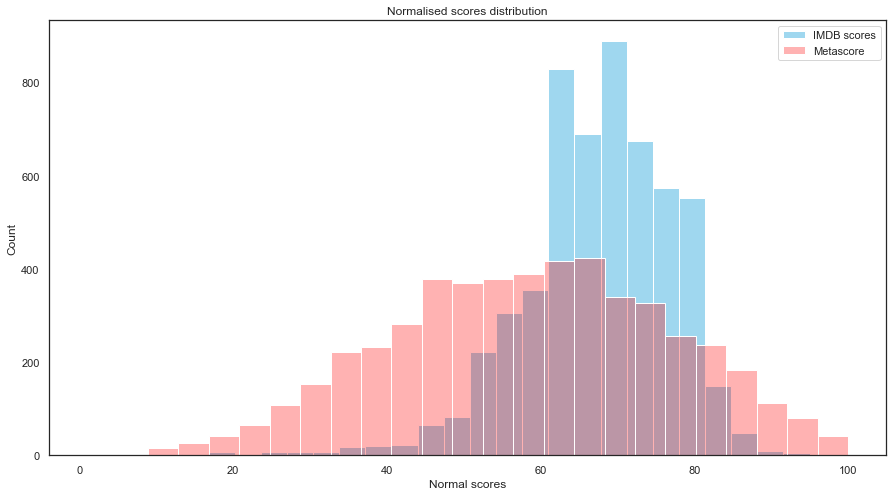

In [190]:
# Plotting both normalized IMDB and Metascore
sns.set(style='white')
plt.figure(figsize=(15,8))
sns.histplot(data=merged_df, x='norm_imdb', color='skyblue', label='IMDB scores', alpha=0.8, bins=25)
sns.histplot(data=merged_df, x='metascore', color='red', label='Metascore', alpha=0.3, bins=25)

plt.title('Normalised scores distribution')
# Set x-axis label
plt.xlabel('Normal scores')
# Set y-axis label
plt.ylabel('Count')

plt.legend() 
plt.show()

We can see from IMDB and Metascore normalised distributions, that Metascore seems to have a more normal shape distribution, whereas IMDB scores tend to be a bit more skewed. Metascore shows a bigger range, while IMDB reviews tend to get a narrower range.

Apparently, I'd say Metascore would be more trustworthy in general, since we would expect that movie ratings distribution would be roughly normal, with a chunk of average movies.

No handles with labels found to put in legend.


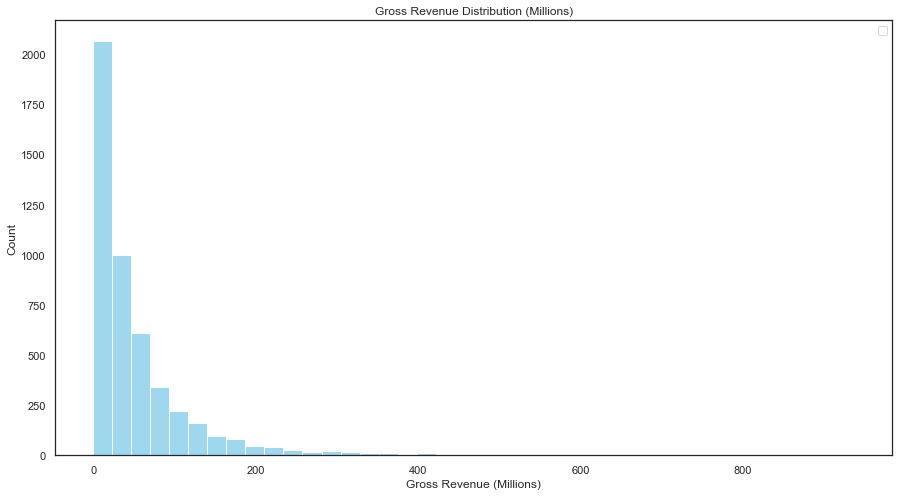

In [138]:
# Plotting revenue distribution
sns.set(style="white")
plt.figure(figsize=(15,8))
sns.histplot(data=merged_df[~np.isnan(merged_df['gross_revenue_milions'])], x='gross_revenue_milions', color='skyblue', alpha=0.8, bins=40)

plt.title('Gross Revenue Distribution (Millions)')
# Set x-axis label
plt.xlabel('Gross Revenue (Millions)')
# Set y-axis label
plt.ylabel('Count')

plt.legend() 
plt.show()

As expected, movies' gross revenue distribution is right skewed, since it's natural that only a few would have higher revenues.

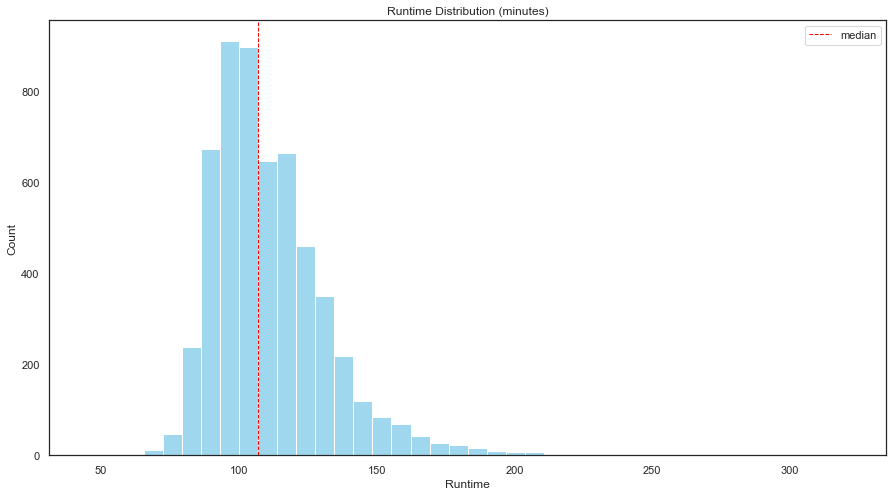

In [139]:
# Plotting runtime distribution
sns.set(style="white")
plt.figure(figsize=(15,8))
sns.histplot(data=merged_df, x='runtime_min', color='skyblue', alpha=0.8, bins=40)

plt.title('Runtime Distribution (minutes)')
# Set x-axis label
plt.xlabel('Runtime')
# Set y-axis label
plt.ylabel('Count')
# Adding median movie minutes
plt.axvline(x=merged_df.runtime_min.median(),
            color='red', ls='--', lw=1, label='median')

plt.legend() 
plt.show()

(-0.5, 999.5, 499.5, -0.5)

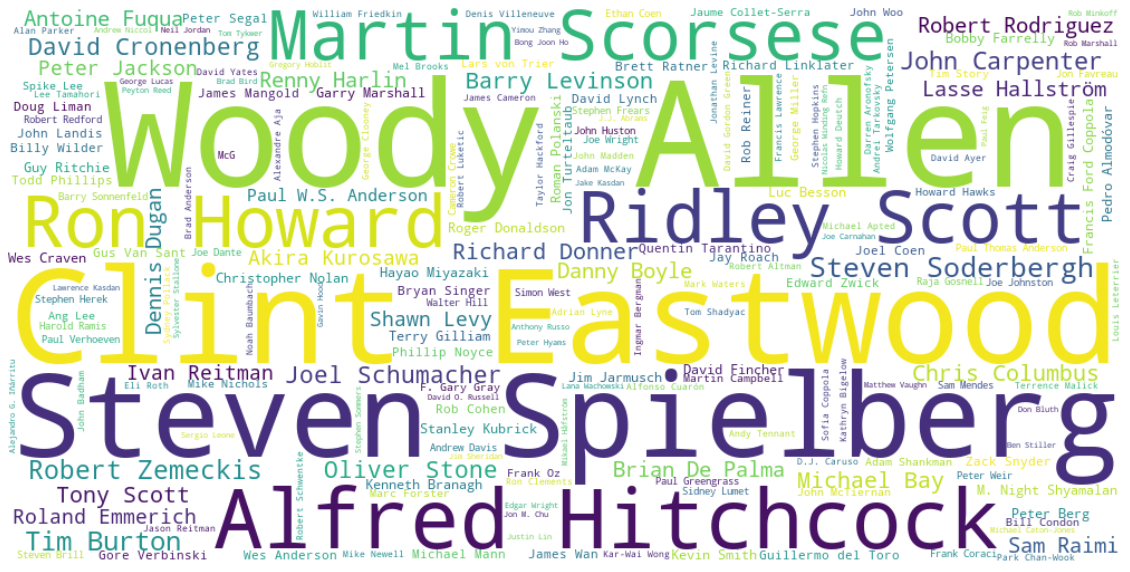

In [140]:
# Creating a word cloud to represent movie directors
# dictionary from director variable
word_could_dict = Counter(list(merged_df.director))
wordcloud = WordCloud(width = 1000, height = 500, 
                      background_color='white').generate_from_frequencies(word_could_dict)

plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

We can definitely spot some very famous names in the word cloud above. Let's explore another word cloud but filtering only movies which's ever been awarded an Oscar, and have had at least one nomination.

In [161]:
aux_filter = merged_df[~np.isnan(merged_df['awards'])]
aux_filter = aux_filter[(aux_filter['awards']>0) & (aux_filter['nominations']>0)]

(-0.5, 999.5, 499.5, -0.5)

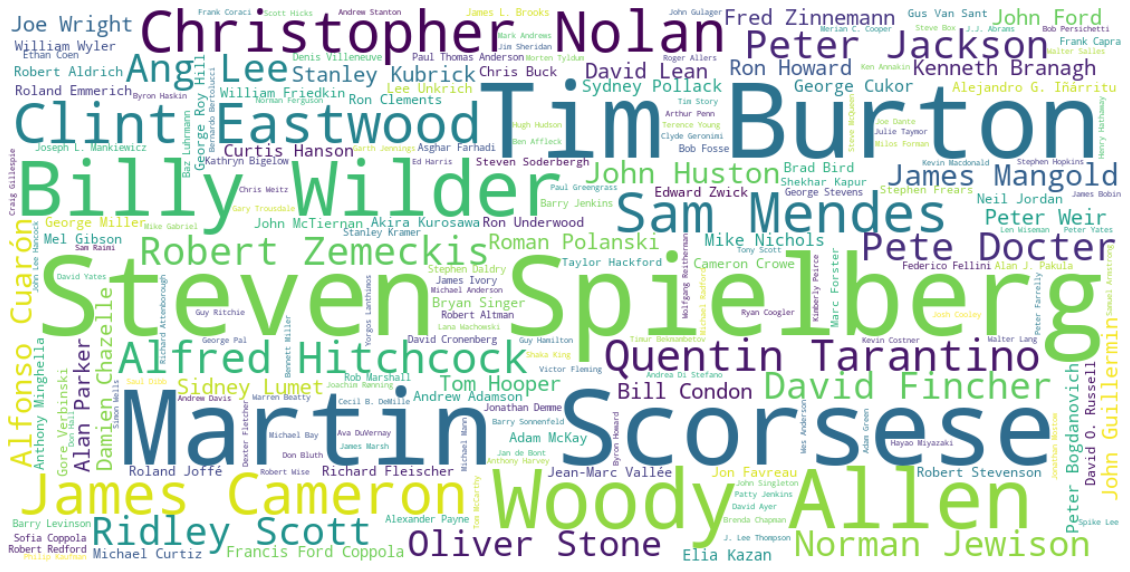

In [163]:
# dictionary from director variable
word_could_dict_aw_nom = Counter(list(aux_filter.director))
wordcloud_aw_nom = WordCloud(width = 1000, height = 500, 
                      background_color='white').generate_from_frequencies(word_could_dict_aw_nom)

plt.figure(figsize=(20,12))
plt.imshow(wordcloud_aw_nom, interpolation='bilinear')
plt.axis('off')

We can see some famous names popping up on the second word cloud that hadn't been that evident on the previous one. <br>
<br>
<br>
Let's also explore the rating distributions for movies that have been awarded at least an Oscar and have had at least one nomination.

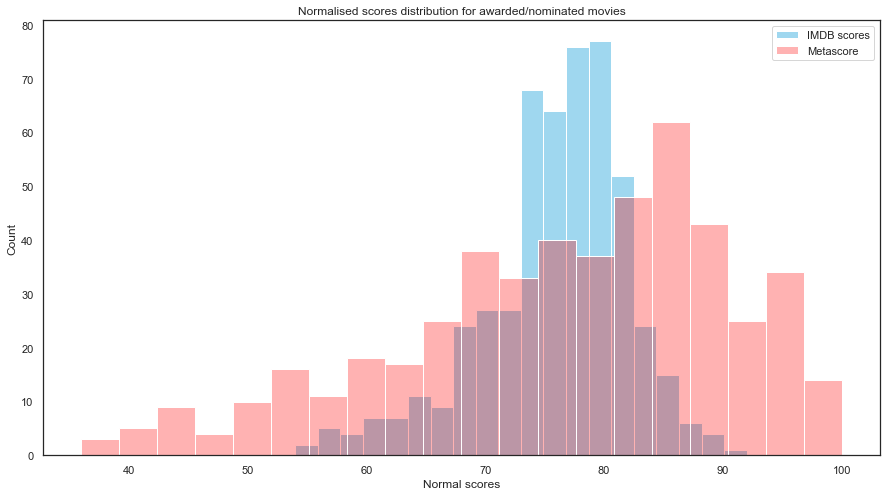

In [167]:
# Plotting both normalized IMDB and Metascore filtered by the criteria above
sns.set(style='white')
plt.figure(figsize=(15,8))
sns.histplot(data=aux_filter, x='norm_imdb', color='skyblue', label='IMDB scores', alpha=0.8, bins=20)
sns.histplot(data=aux_filter, x='metascore', color='red', label='Metascore', alpha=0.3, bins=20)

plt.title('Normalised scores distribution for awarded/nominated movies')
# Set x-axis label
plt.xlabel('Normal scores')
# Set y-axis label
plt.ylabel('Count')

plt.legend() 
plt.show()

Comparing this histogram with the other (without filtering), we can notice that especially Metascore shows now a left skewed distribution (not normal anymore), indicating that in general, awarded movies tend to have higher ratings, which is something in line for what we'd expect.